In [1]:
%run convention.ipynb

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
import os
os.chdir(r'C:\Users\dell\PycharmProjects\MachineLearning\Pandas\datasets')

In [3]:
train_data = pd.read_csv('./titanic/train.csv')
test_data = pd.read_csv('./titanic/test.csv')
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        return X[self.features]

In [6]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        most_frequent = [X[col].value_counts().index[0]  for col in X]
        self.most_frequent = pd.Series(most_frequent, index = X.columns)
        return self
    def transform(self, X, y = None):
        return X.fillna(self.most_frequent)
        

In [7]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

num_pipe = Pipeline([
    ('selector', FeatureSelector(num_features)),
    ('imputer', SimpleImputer(strategy = 'median'))
])

In [8]:
num_pipe.fit_transform(train_data)

array([[ 3.    , 22.    ,  1.    ,  0.    ,  7.25  ],
       [ 1.    , 38.    ,  1.    ,  0.    , 71.2833],
       [ 3.    , 26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    , 28.    ,  1.    ,  2.    , 23.45  ],
       [ 1.    , 26.    ,  0.    ,  0.    , 30.    ],
       [ 3.    , 32.    ,  0.    ,  0.    ,  7.75  ]])

In [9]:
cat_features = ['Sex', 'Cabin', 'Embarked']
cat_pipe = Pipeline([
    ('selector', FeatureSelector(cat_features)),
    ('imputer', CategoricalImputer()),
    ('encoder', OneHotEncoder(sparse = False))
    
])

In [10]:
cat_pipe.fit_transform(train_data)

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [11]:
pipe = FeatureUnion([
    ('num', num_pipe),
    ('cat', cat_pipe)
])

In [12]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])
params = {
    'svm__C' : [.001, .01, .1, 1, 10, 100],
    'svm__gamma': [.01, .1, 1, 10]
}

grid = GridSearchCV(model, params, cv = 10)

In [13]:
X_train, y_train = train_data.drop(columns = 'Survived'), train_data['Survived']
X_train = pipe.fit_transform(X_train)

In [14]:
grid.fit(X_train, y_train)

C:\Users\dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svm',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
               

In [16]:
grid.best_score_

0.8170594837261503

In [17]:
grid.best_params_

{'svm__C': 10, 'svm__gamma': 0.1}

<p class = 'note'>Let's evaluate our model:</p>

In [18]:
from sklearn.model_selection import cross_val_score
svm_clf = grid.best_estimator_
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv = 10)
svm_scores

array([0.8       , 0.77777778, 0.7752809 , 0.79775281, 0.85393258,
       0.83146067, 0.78651685, 0.80898876, 0.88764045, 0.85227273])

In [26]:
svm_scores.mean()

0.817162353875837

<p class = 'note'>Can we do this better? Let's try Boosting....</p>

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

gb_scores = cross_val_score(gb_clf, X_train, y_train, cv = 10)

In [20]:
gb_scores

array([0.81111111, 0.78888889, 0.76404494, 0.86516854, 0.88764045,
       0.83146067, 0.82022472, 0.7752809 , 0.87640449, 0.84090909])

In [27]:
gb_scores.mean()

0.8261133810010215

Text(0, 0.5, 'Cross-validation score')

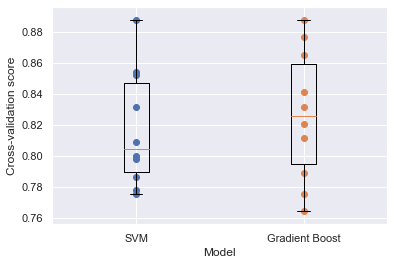

In [31]:
plt.boxplot([svm_scores, gb_scores], labels = ['SVM', 'Gradient Boost'])
plt.scatter([1] * 10, svm_scores)
plt.scatter([2] * 10, gb_scores)
plt.xlabel('Model')
plt.ylabel('Cross-validation score')

# Improvements

<pre>
To improve this result further, you could:

Compare many more models and tune hyperparameters using cross validation and grid search,
Do more feature engineering, for example:
replace SibSp and Parch with their sum,
try to identify parts of names that correlate well with the Survived attribute (e.g. if the name contains "Countess", then survival seems more likely),
try to convert numerical attributes to categorical attributes: for example, different age groups had very different survival rates (see below), so it may help to create an age bucket category and use it instead of the age. Similarly, it may be useful to have a special category for people traveling alone since only 30% of them survived (see below).
    </pre>

In [32]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [47]:
title = train_data['Name'].str.split(' ').apply(lambda x: x[1])
title.value_counts()

Mr.             502
Miss.           179
Mrs.            121
Master.          40
Dr.               7
Rev.              6
y                 4
Impe,             3
Planke,           3
Mlle.             2
Major.            2
Gordon,           2
Col.              2
Steen,            1
Carlo,            1
Capt.             1
Pelsmaeker,       1
Mulder,           1
Melkebeke,        1
Velde,            1
the               1
Messemaeker,      1
Don.              1
Shawah,           1
Cruyssen,         1
Billiard,         1
Jonkheer.         1
Walle,            1
der               1
Mme.              1
Ms.               1
Name: Name, dtype: int64

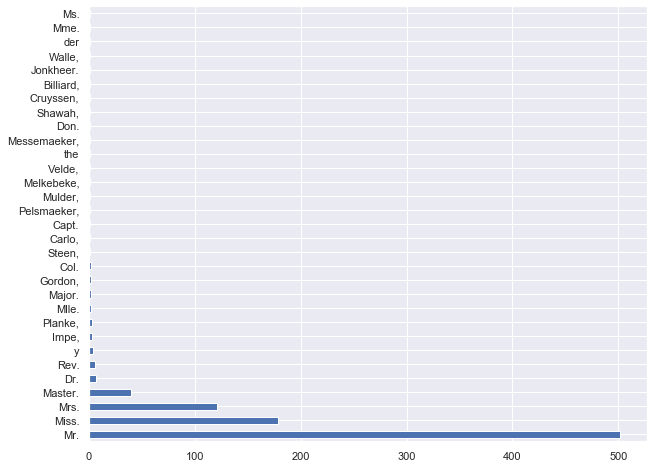

In [48]:
plt.figure(figsize = (10, 8))
title.value_counts().plot(kind = 'barh')

<p>We can see that <b>Mr, Miss, Mrs, Master</b> is most common, so let replace the other titles with "Other"</p>

In [51]:
title[~title.isin(['Mr.', 'Miss.', 'Mrs', 'Master.'])] = 'Other'
title.value_counts() / len(title)

Mr.        0.563412
Miss.      0.200898
Other      0.190797
Master.    0.044893
Name: Name, dtype: float64

In [52]:
train_data['title'] = title
train_data.groupby('title')['Survived'].sum()

title
Master.     23
Miss.      126
Mr.         79
Other      114
Name: Survived, dtype: int64

The total number of people accompany:

In [70]:
train_data['accompany'] = train_data['Parch'] + train_data['SibSp']
train_data.groupby('accompany')['Survived'].mean()

accompany
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

<p class = 'note'>We can infer that people who go with few people tend to survive</p>

In [56]:
train_data['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [78]:
age_bin = pd.cut(train_data['Age'], [0, 15, 30, 45, 60, 80], labels = ['young', 'young adult', 'adult', 'senior', 'older'])
train_data['age_bin'] = age_bin
train_data.groupby(age_bin).Survived.mean()


Age
young          0.590361
young adult    0.358896
adult          0.425743
senior         0.407407
older          0.227273
Name: Survived, dtype: float64

In [79]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'title', 'accompany',
       'age_bin'],
      dtype='object')

In [76]:

num_pipe = make_pipeline(
    FeatureSelector(['Pclass','SibSp','Parch','accompany','Fare']),
    SimpleImputer(strategy = 'median')
)

In [84]:
num_pipe.fit_transform(train_data)

array([[ 3.    ,  1.    ,  0.    ,  1.    ,  7.25  ],
       [ 1.    ,  1.    ,  0.    ,  1.    , 71.2833],
       [ 3.    ,  0.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [ 3.    ,  1.    ,  2.    ,  3.    , 23.45  ],
       [ 1.    ,  0.    ,  0.    ,  0.    , 30.    ],
       [ 3.    ,  0.    ,  0.    ,  0.    ,  7.75  ]])

In [80]:
cat_pipe = make_pipeline(
    FeatureSelector(['Sex', 'Cabin', 'Embarked', 'title', 'age_bin']),
    CategoricalImputer(),
    OneHotEncoder(sparse = False)
)

In [83]:
cat_pipe.fit_transform(train_data)

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [87]:
processing = FeatureUnion([('num', num_pipe), ('cat', cat_pipe)])
X_train = train_data.drop(columns = 'Survived')
X_train = processing.fit_transform(X_train)


In [88]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
scores = cross_val_score(clf, X_train, y_train, cv = 10)
scores

array([0.82222222, 0.84444444, 0.76404494, 0.87640449, 0.86516854,
       0.82022472, 0.84269663, 0.7752809 , 0.88764045, 0.82954545])

In [90]:
scores.mean()

0.8327672795369425